## HW3: Decision Tree and Random Forest
In hw3, you need to implement decision tree and random forest by using only numpy, then train your implemented model by the provided dataset and test the performance with testing data

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling sklearn.tree.DecisionTreeClassifier

In [1]:
!pip install sklearn

## Load data

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

In [3]:
data = load_breast_cancer()
feature_names = data['feature_names']
print(feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [4]:
x_train = pd.read_csv("x_train.csv")
y_train = pd.read_csv("y_train.csv")
x_test = pd.read_csv("x_test.csv")
y_test = pd.read_csv("y_test.csv")
#print(x_train.values[:, 0])
print(x_test.values.shape[0])

143


## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 7 of hw3 slides](https://docs.google.com/presentation/d/1ish3jEr_6be0FK4kgOZa12nYAyJFh0P2LCNsNPOCiXo/edit#slide=id.g7703d1636d_0_21)

In [5]:
def gini(sequence):
    cal = np.zeros(3)
    gini_index = 1
    for i in range (3):
        cal[i] = len(np.where(sequence == i)[0])
        gini_index -= pow((cal[i] / len(sequence)), 2)
        #print("{}".format(np.where(sequence == i)))
        
    return gini_index

def entropy(sequence):
    Entropy = 0
    cal = np.zeros(3)
    for i in range (3):
        cal[i] = len(np.where(sequence == i)[0])
        if(cal[i] == 0):
            continue
        Entropy -= (cal[i] / len(sequence)) * np.log2(cal[i] / len(sequence))
        #print("{}".format(Entropy))
        
    return Entropy

In [6]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [7]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [8]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the test data. You should implement two arguments for the Decision Tree algorithm
1. **Criterion**: The function to measure the quality of a split. Your model should support “gini” for the Gini impurity and “entropy” for the information gain. 
2. **Max_depth**: The maximum depth of the tree. If Max_depth=None, then nodes are expanded until all leaves are pure. Max_depth=1 equals to split data once


In [9]:
class Question():
    def __init__(self, feature, value):
        self.feature = feature
        self.value = value
    
    def check(self, x):
        true = np.where(x[:, self.feature] >= self.value)
        false = np.where(x[:, self.feature] < self.value)
        
        return true, false
        

In [10]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None):
        self.criterion = criterion
        self.max_depth = max_depth
        #print("init")
        
    def start(self, x, y):
        self.importance = np.zeros(x_train.values.shape[1])
        self.tree = self.build(x, y, 0, self.max_depth)
        #print("start")
   
    def split(self, x, y, question):
        true_index, false_index = Question.check(question, x)
       
        trueX = np.array(x[true_index])
        trueY = np.array(y[true_index])
        #print(trueY.T)
        falseX = np.array(x[false_index])
        falseY = np.array(y[false_index])
        #print("split")
        return trueX, falseX, trueY, falseY
                
    def purest(self, x, y):
        #left = 2
        #right = 2
        purity = 2
        best = None
        for idx in range(len(x[0])):
            values = set([temp[idx] for temp in x])
            #print(len(values))
            for val in values:
                question = Question(idx, val)
                trueX, falseX, trueY, falseY = self.split(x, y, question)
                
                if len(trueX) == 0 or len(falseX) == 0:
                    continue
                    
                if self.criterion == 'gini':
                    left_purity = gini(trueY)
                    right_purity = gini(falseY)
                else:
                    left_purity = entropy(trueY)
                    right_purity = entropy(falseY)
                
                weight = len(trueY) / (len(trueY) + len(falseY))
                #print(weight)
                #print(left_purity)
                result = left_purity * weight + right_purity * (1-weight)
                
                if result < purity:
                    purity = result
                    best = question
        #print("purest")
        #print(purity)
        #print(best)
        return purity, best     
                    
    def build(self, x, y, depth, max_depth):
        if gini(y) == 0:
            class0 = np.where(y[:, 0] == 0)
            #print(y[class0])
            class1 = np.where(y[:, 0] == 1)
            counts = {}
            counts[0] = len(y[class0])
            counts[1] = len(y[class1])
            return counts
        
        purity, question = self.purest(x, y)
        
        if (max_depth is not None and depth >= max_depth) or question == None:
            class0 = np.where(y[:, 0] == 0)
            #print(y[class0])
            class1 = np.where(y[:, 0] == 1)
            counts = {}
            counts[0] = len(y[class0])
            counts[1] = len(y[class1])
            return counts
        
        self.importance[question.feature] +=1
        trueX, falseX, trueY, falseY = self.split(x, y, question)
        
        true_branch = self.build(trueX, trueY, depth + 1, max_depth)
        false_branch = self.build(falseX, falseY, depth + 1, max_depth)
        
        #print("build")
        
        return Node(question, true_branch, false_branch)
    
    def predict(self, x):
        prediction = np.zeros(x.shape[0])
        for idx in range(x.shape[0]):
            node = self.find_node(x[idx], self.tree)
            if node[0] < node[1]:
                prediction[idx] = 1
        return prediction

    def find_node(self, row, tree):
        if isinstance(tree, dict):
            return tree
        if row[tree.question.feature] >= tree.question.value:
            return self.find_node(row, tree.true_branch)
        else:
            return self.find_node(row, tree.false_branch)

    def evaluate(self, predicted, truth):
        correct = 0
        for i in range(len(predicted)):
            if predicted[i] == truth[i][0]:
                correct += 1
        print("Testing accuracy is: {} with {} / {}".format(correct / len(predicted), correct, len(predicted)))
           

In [11]:
class Node:
    def __init__(self, question, true_branch, false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

### Question 2.1
Using Criterion=‘gini’, showing the accuracy score of test data by Max_depth=3 and Max_depth=10, respectively.


In [25]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth3.start(x_train.values, y_train.values)
prediction = clf_depth3.predict(x_test.values)
#print(prediction)
correct = 0
for i in range(len(prediction)):
    if prediction[i] == y_test.values[i][0]:
        correct += 1
print("Accuracy % is: {} with {} / {}".format(correct / len(prediction), correct, len(prediction)))

Accuracy % is: 0.9300699300699301 with 133 / 143


In [26]:
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)
clf_depth10.start(x_train.values, y_train.values)
prediction = clf_depth10.predict(x_test.values)
#print(prediction)
correct = 0
for i in range(len(prediction)):
    if prediction[i] == y_test.values[i][0]:
        correct += 1
print("Accuracy % is: {} with {} / {}".format(correct / len(prediction), correct, len(prediction)))

Accuracy % is: 0.9300699300699301 with 133 / 143


### Question 2.2
Using Max_depth=3, showing the accuracy score of test data by Criterion=‘gini’ and Criterion=’entropy’, respectively.


In [16]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_gini.start(x_train.values, y_train.values)
prediction = clf_gini.predict(x_test.values)
#print(prediction)
correct = 0
for i in range(len(prediction)):
    if prediction[i] == y_test.values[i][0]:
        correct += 1
print("Accuracy % is: {} with {} / {}".format(correct / len(prediction), correct, len(prediction)))

Testing accuracy is: 0.9300699300699301 with 133 / 143


In [17]:
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
clf_entropy.start(x_train.values, y_train.values)
prediction = clf_entropy.predict(x_test.values)
#print(prediction)
correct = 0
for i in range(len(prediction)):
    if prediction[i] == y_test.values[i][0]:
        correct += 1
print("Accuracy % is: {} with {} / {}".format(correct / len(prediction), correct, len(prediction)))

Testing accuracy is: 0.9440559440559441 with 135 / 143


- Note: All of your accuracy scores should over 0.9
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the feature counts for building tree without normalize the importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

<BarContainer object of 30 artists>

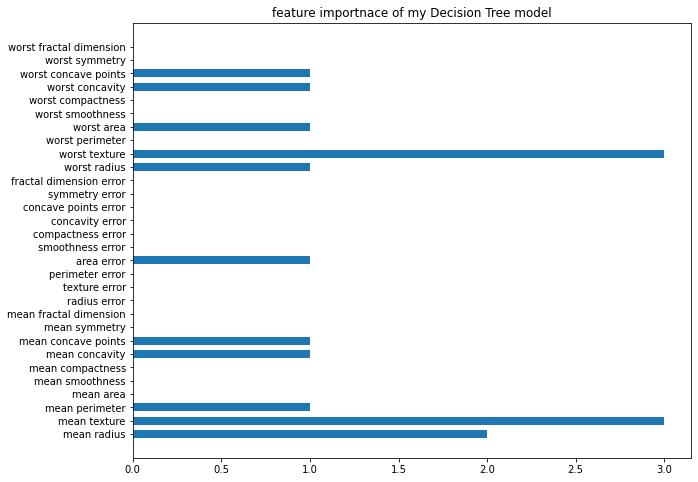

In [18]:
feature_counts = clf_depth10.importance
#print(x_train[0].values)
x = np.array(x_train.columns)
#y = np.array([1 ,2 ,3, 4, 5])
plt.figure(figsize=(10,8))
plt.title('feature importnace of my Decision Tree model')

plt.barh(x, feature_counts, height = 0.6)

## Question 4
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement two arguments for the Random Forest.

1. **N_estimators**: The number of trees in the forest. 
2. **Max_features**: The number of random select features to consider when looking for the best split
3. **Bootstrap**: Whether bootstrap samples are used when building tree


In [19]:
class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        return None
    
    def random(self, x, y):
        random_forest = []
        for idx in range (self.n_estimators):
            random_data = np.random.choice(x.shape[0], x.shape[0],  replace = True)
            random_feature = np.random.choice(x.shape[1], int(self.max_features), replace = False)
            rowX = x[random_data, :]
            rowY = y[random_data, :]
            column = rowX[:, random_feature]
            random_forest.append(([self.build(rowY, column), random_feature]))
        #print(random_forest)
        self.random_forest = random_forest    
    def build(self, y, column):
        tree = DecisionTree(criterion=self.criterion, max_depth=self.max_depth)
        tree.start(column, y)       
        return tree    
    def predict(self, x):
        prediction = np.zeros(x.shape[0])
        for idx in range(x.shape[0]):
            compare = np.zeros(2)
            for tree in range(self.n_estimators):
                column = x[:, self.random_forest[tree][1]]
                node = self.random_forest[tree][0].find_node(column[idx], self.random_forest[tree][0].tree)
                if node[0] > node[1]:
                    compare[0] += 1
                else:
                    compare[1] += 1
                    
            if(compare[0] < compare[1]):
                prediction[idx] = 1
        print(prediction)
        return prediction
            
        
            

### Question 4.1
Using Criterion=‘gini’, Max_depth=None, Max_features=sqrt(n_features), showing the accuracy score of test data by n_estimators=10 and n_estimators=100, respectively.


In [20]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_10tree.random(x_train.values, y_train.values)
prediction = clf_10tree.predict(x_test.values)
correct = 0
for i in range(len(prediction)):
    if prediction[i] == y_test.values[i][0]:
        correct += 1
print("Accuracy % is: {} with {} / {}".format(correct / len(prediction), correct, len(prediction)))
#print(len(x_test.values))

[0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1.]
Testing accuracy is: 0.9300699300699301 with 133 / 143


In [21]:
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))
clf_100tree.random(x_train.values, y_train.values)
prediction = clf_100tree.predict(x_test.values)
correct = 0
for i in range(len(prediction)):
    if prediction[i] == y_test.values[i][0]:
        correct += 1
print("Accuracy % is: {} with {} / {}".format(correct / len(prediction), correct, len(prediction)))

[0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1.]
Testing accuracy is: 0.9440559440559441 with 135 / 143


### Question 4.2
Using Criterion=‘gini’, Max_depth=None, N_estimators=10, showing the accuracy score of test data by Max_features=sqrt(n_features) and Max_features=n_features, respectively.


In [22]:
clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])
clf_all_features.random(x_train.values, y_train.values)
prediction = clf_all_features.predict(x_test.values)
correct = 0
for i in range(len(prediction)):
    if prediction[i] == y_test.values[i][0]:
        correct += 1
print("Accuracy % is: {} with {} / {}".format(correct / len(prediction), correct, len(prediction)))

[0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1.]
Testing accuracy is: 0.9440559440559441 with 135 / 143


In [23]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_random_features.random(x_train.values, y_train.values)
prediction = clf_random_features.predict(x_test.values)
correct = 0
for i in range(len(prediction)):
    if prediction[i] == y_test.values[i][0]:
        correct += 1
print("Accuracy % is: {} with {} / {}".format(correct / len(prediction), correct, len(prediction)))

[1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1.]
Testing accuracy is: 0.958041958041958 with 137 / 143


- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 